In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

In [2]:
# you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
    raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

BES_code_folder   = "../BES_analysis_code/" # we should be here!
BES_small_data_files = BES_code_folder + "small data files" + os.sep
if not os.path.exists( BES_small_data_files ):
    os.makedirs( BES_small_data_files )

# we should create these if they don't already exist
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )

BES_output_folder = "../BES_analysis_output/"
if not os.path.exists( BES_output_folder ):
    os.makedirs( BES_output_folder )
    
BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

BES_R_data_files = BES_data_folder + "R_data" + os.sep
if not os.path.exists( BES_R_data_files ):
    os.makedirs( BES_R_data_files )


In [3]:
dataset_name = "W13_comb"

In [4]:
%%time

manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

data_subfolder = BES_data_folder + dataset_name + os.sep

dataset_filename = manifest["Stata_Filename"].values[0]
# dataset_description = manifest["Friendlier_Description"].values[0]
# dataset_citation = manifest["Citation"].values[0]
# dataset_start = manifest["Date_Start"].values[0]
# dataset_stop = manifest["Date_Stop"].values[0]
# dataset_wave = manifest["Wave No"].values[0]

BES_Panel  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
print("BES_Panel", BES_Panel.shape )

BES_Panel (68625, 5150)
Wall time: 3.31 s


In [5]:
####

# BES_numeric = pd.read_hdf( data_subfolder + "BESnumeric.hdf", "BESnumeric" )
# print("BES_numeric",  BES_numeric.shape )
try:
    var_type    = pd.read_hdf( data_subfolder + "var_type.hdf", encoding=encoding)
except:
    var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
    var_type.set_index("Unnamed: 0", inplace=True)
print("var_type",  var_type.shape )

fname = data_subfolder + "cat_dictionary.pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )
    
####

# BES_non_numeric = pd.read_hdf( data_subfolder + "BESnon_numeric.hdf", "BESnon_numeric" )
# print("BES_non_numeric",  BES_non_numeric.shape )

BES_reduced = pd.read_hdf( data_subfolder + "BES_reduced.hdf", "BES_reduced" )
print("BES_reduced",  BES_reduced.shape )

BES_reduced_with_na = pd.read_hdf( data_subfolder + "BES_reduced_with_na.hdf", "BES_reduced_with_na")
print("BES_reduced_with_na", BES_reduced_with_na.shape )

# fname = data_subfolder + "new_old_col_names.pkl"
# with open(fname, "rb") as f:
#     new_old_col_names = pickle.load(f) 

var_type (5173, 12)
BES_reduced (68625, 2572)
BES_reduced_with_na (68625, 2572)


In [6]:
#####
##### Lib dems support VI
##### compared to difference between like for two leaders/parties?




# England Only
# W1-6
# Cameron - Miliband -> Clegg
# Con - Lab -> LD

# W7-9
# Cameron - Corbyn -> Farron

# W10-13
# May - Corbyn -> Farron


In [93]:
Conservative_leader = {n: "Cameron" if n <10 else "May" for n in range(1,14)}
Labour_leader = {n: "Miliband" if n <7 else "Corbyn" for n in range(1,14)}
LD_leader = {n: "Clegg" if n <7 else "Farron" for n in range(1,14)}


In [184]:
[x for x in BES_Panel.columns if "profile_past_vote" in x]

['profile_past_vote_2005', 'profile_past_vote_2010', 'profile_past_vote_2015']

In [186]:
BES_Panel['profile_past_vote_2010'].cat.categories

Index(['Did not vote', 'Conservative Party', 'Labour Party',
       'Liberal Democrats', 'Scottish National Party', 'Plaid Cymru',
       'British National Party (BNP)', 'Green Party', 'Respect',
       'United Kingdom Independence Party (UKIP)', 'Some other party',
       'Don't know'],
      dtype='object')

-1     38277
 0      8093
 1      2455
 2      2395
 3      2348
 4      2150
 5      3309
 6      2521
 7      2809
 8      1889
 9       730
 10      723
 11      926
dtype: int64

In [15]:
BES_Panel['likeCameronW1'].cat.codes.replace(-1,np.nan).replace(11,5).value_counts().sort_index()

0.0     8093
1.0     2455
2.0     2395
3.0     2348
4.0     2150
5.0     4235
6.0     2521
7.0     2809
8.0     1889
9.0      730
10.0     723
dtype: int64

In [117]:
wave_description = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"][["Wave No","Friendlier_Description"]].set_index("Wave No")

11

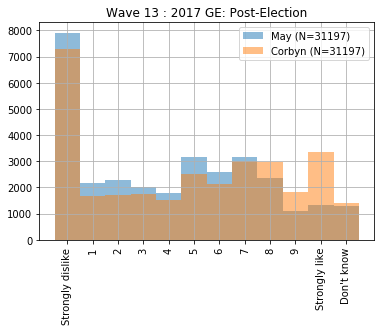

In [140]:
wave_no = 13
DKs_transformed = False

Con_name = Conservative_leader[wave_no]
Con_var = "like"+Con_name+"W"+str(wave_no)
Lab_name = Labour_leader[wave_no]
Lab_var = "like"+Lab_name+"W"+str(wave_no)

likeCon = BES_Panel[Con_var].cat.codes.replace(-1,np.nan)
likeLab = BES_Panel[Lab_var].cat.codes.replace(-1,np.nan)
if DKs_transformed:
    likeCon = likeCon.replace(11,5)
    likeLab = likeLab.replace(11,5)

likeCon_label = Con_name+' (N='+str(likeCon.notnull().sum())+')'
likeLab_label = Lab_name+' (N='+str(likeLab.notnull().sum())+')'

xlabels = BES_Panel[Con_var].cat.categories[0:len(likeCon.value_counts())]
bins = np.arange(len(xlabels)+1)-.5

likeCon.hist(alpha=.5, label=likeCon_label, bins=bins, grid=True)
likeLab.hist(alpha=.5, label=likeLab_label, bins=bins, grid=True)
plt.legend()

plt.xticks(range(0,len(xlabels)), xlabels, rotation =90);
plt.title("Wave "+str(wave_no)+" : "+wave_description.loc[wave_no].values[0]);

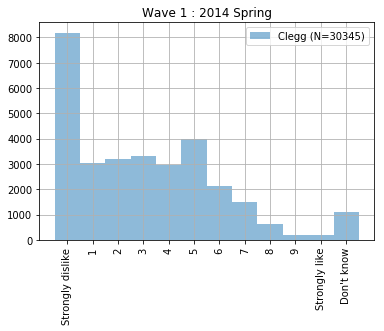

In [142]:
wave_no = 1
DKs_transformed = False

Con_name = Conservative_leader[wave_no]
Con_var = "like"+Con_name+"W"+str(wave_no)
Lab_name = Labour_leader[wave_no]
Lab_var = "like"+Lab_name+"W"+str(wave_no)
LD_name = LD_leader[wave_no]
LD_var = "like"+LD_name+"W"+str(wave_no)

likeLD = BES_Panel[LD_var].cat.codes.replace(-1,np.nan)
if DKs_transformed:
    likeLD = likeLD.replace(11,5)

likeLD_label = LD_name+' (N='+str(likeLD.notnull().sum())+')'

xlabels = BES_Panel[Con_var].cat.categories[0:len(likeLD.value_counts())]
bins = np.arange(len(xlabels)+1)-.5

likeLD.hist(alpha=.5, label=likeLD_label, bins=bins, grid=True)
plt.legend()

plt.xticks(range(0,len(xlabels)), xlabels, rotation =90);
plt.title("Wave "+str(wave_no)+" : "+wave_description.loc[wave_no].values[0]);

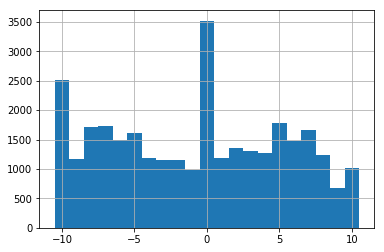

In [163]:
wave_no = 13
DKs_transformed = True

Con_name = Conservative_leader[wave_no]
Con_var = "like"+Con_name+"W"+str(wave_no)
Lab_name = Labour_leader[wave_no]
Lab_var = "like"+Lab_name+"W"+str(wave_no)

likeCon = BES_Panel[Con_var].cat.codes.replace(-1,np.nan)
likeLab = BES_Panel[Lab_var].cat.codes.replace(-1,np.nan)
if DKs_transformed:
    likeCon = likeCon.replace(11,5)
    likeLab = likeLab.replace(11,5)

likeCon_label = Con_name+' (N='+str(likeCon.notnull().sum())+')'
likeLab_label = Lab_name+' (N='+str(likeLab.notnull().sum())+')'

bins = np.arange(-10,12)-.5

(likeCon-likeLab).hist(bins=bins);

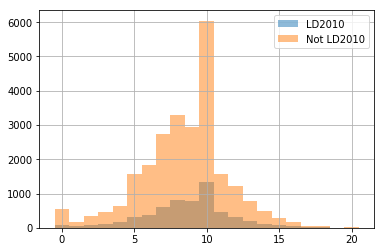

In [193]:
wave_no = 13
DKs_transformed = True
Leaders = True

if Leaders:
    Con_name = Conservative_leader[wave_no]
    Con_var = "like"+Con_name+"W"+str(wave_no)
    Lab_name = Labour_leader[wave_no]
    Lab_var = "like"+Lab_name+"W"+str(wave_no)    
    LD_name = LD_leader[wave_no]
    LD_var = "like"+LD_name+"W"+str(wave_no)    
else:
    Con_name = "Con"
    Con_var = "like"+Con_name+"W"+str(wave_no)
    Lab_name = "Lab"
    Lab_var = "like"+Lab_name+"W"+str(wave_no)
    LD_name = "LD"
    LD_var = "like"+LD_name+"W"+str(wave_no)

likeLD = BES_Panel[LD_var].cat.codes.replace(-1,np.nan)
likeCon = BES_Panel[Con_var].cat.codes.replace(-1,np.nan)
likeLab = BES_Panel[Lab_var].cat.codes.replace(-1,np.nan)
if DKs_transformed:
    likeCon = likeCon.replace(11,5)
    likeLab = likeLab.replace(11,5)
    likeLD = likeLD.replace(11,5)

likeCon_label = Con_name+' (N='+str(likeCon.notnull().sum())+')'
likeLab_label = Lab_name+' (N='+str(likeLab.notnull().sum())+')'

bins = np.arange(-10,12)-.5

# (likeCon-likeLab)[likeLD<5].hist(bins=bins,label="Don't like LD",alpha=.5);
# (likeCon-likeLab)[likeLD>5].hist(bins=bins,label="Like LD",alpha=.5);
# (likeCon-likeLab)[likeLD==5].hist(bins=bins,label="Meh LD",alpha=.5);

LD2010 = BES_Panel['profile_past_vote_2010']=='Liberal Democrats'
# (likeCon-likeLab)[LD2010].hist(bins=bins,label="LD2010",alpha=.5);
# (likeCon-likeLab)[~LD2010].hist(bins=bins,label="Not LD2010",alpha=.5);

bins = np.arange(0,22)-.5
(likeCon+likeLab)[LD2010].hist(bins=bins,label="LD2010",alpha=.5);
(likeCon+likeLab)[~LD2010].hist(bins=bins,label="Not LD2010",alpha=.5);

plt.legend();

In [178]:
likeLD.value_counts()

5.0     7356
0.0     5287
4.0     3091
6.0     3035
3.0     2895
2.0     2630
7.0     2414
1.0     2174
8.0     1425
9.0      503
10.0     387
dtype: int64

In [10]:
[x for x in BES_Panel.columns if re.match("likeCorbyn|likeLab|profile_eurefvote",x)]

['likeLabW1',
 'likeLabW2',
 'likeLabW3',
 'likeLabW4',
 'likeLabW5',
 'likeLabW6',
 'likeCorbynW7',
 'likeLabW7',
 'likeCorbynW8',
 'likeLabW8',
 'likeCorbynW9',
 'likeLabW9',
 'likeCorbynW10',
 'likeLabW10',
 'likeCorbynW11',
 'likeLabW11',
 'likeCorbynW12',
 'likeLabW12',
 'likeCorbynW13',
 'likeLabW13',
 'profile_eurefvote']

In [29]:
[x for x in BES_reduced.columns if re.match("likeCorbynW13|likeLabW13|profile_eurefvote|generalElectionVoteW13|euRefVote|ptv\w*W13",x)]

['likeCorbynW13__Strongly like',
 'likeLabW13__Strongly like',
 'ptvConW13__Very likely',
 'ptvLabW13__Very likely',
 'ptvLDW13__Very likely',
 'ptvUKIPW13__Very likely',
 'ptvGrnW13__Very likely',
 'generalElectionVoteW13_Labour',
 'generalElectionVoteW13_Liberal Democrat',
 'generalElectionVoteW13_Scottish National Party (SNP)',
 'generalElectionVoteW13_United Kingdom Independence Party (UKIP)',
 'generalElectionVoteW13_Green Party',
 'generalElectionVoteW13_Plaid Cymru',
 'euRefVoteW4_Leave the EU',
 'euRefVoteW8_Leave the EU',
 'euRefVoteW6_Leave the EU',
 'euRefVoteW7_Leave the EU',
 'euRefVoteW12_Leave the EU',
 'profile_eurefvote_Leave the EU',
 'euRefVoteW1_Leave the EU',
 'euRefVoteW10_Leave the EU',
 'euRefVoteW3_Leave the EU']

In [ ]:
############### Would supporting Remain hurt Corbyn?

### impact estimation - look at how much Labour Leavers like Corbyn now

# could also look at ptv

# metric for "give a shit about Brexit" *other than* past vote?



C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


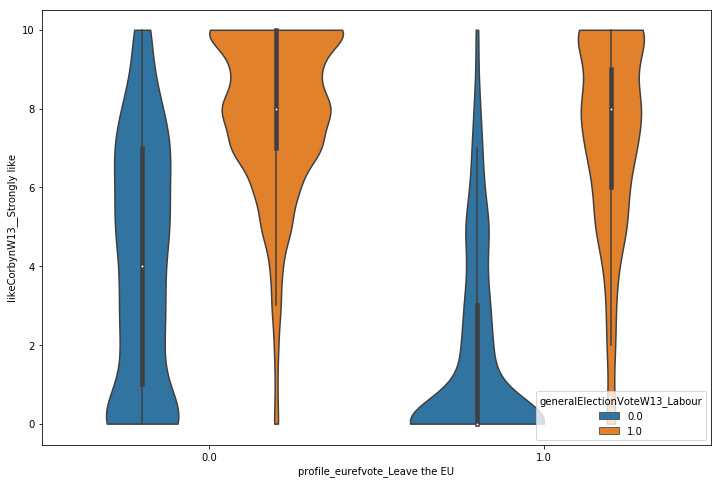

In [10]:
plt.figure(figsize=(12,8))
g = sns.violinplot(x='profile_eurefvote_Leave the EU',
                y='likeCorbynW13__Strongly like',
                hue='generalElectionVoteW13_Labour', data=BES_reduced_with_na, cut=0, bw=.25)

In [11]:
Labour = BES_reduced_with_na['generalElectionVoteW13_Labour']==1.0
Leave = BES_reduced_with_na['profile_eurefvote_Leave the EU']==1.0
Remain = BES_reduced_with_na['profile_eurefvote_Leave the EU']==0.0
# sum(Leave & Labour) = 3123

In [121]:
Leave2017  = BES_Panel["euRefVoteW13"] == "Leave the EU"
Remain2017 = BES_Panel["euRefVoteW13"] == "Stay/remain in the EU"
EUDK2017   = (BES_Panel["euRefVoteW13"] == "Don't know") | (BES_Panel["euRefVoteW13"] == "I would/will not vote")

Stay/remain in the EU    0.701257
Leave the EU             0.248188
Don't know               0.041013
I would/will not vote    0.009542
Name: euRefVoteW13, dtype: float64

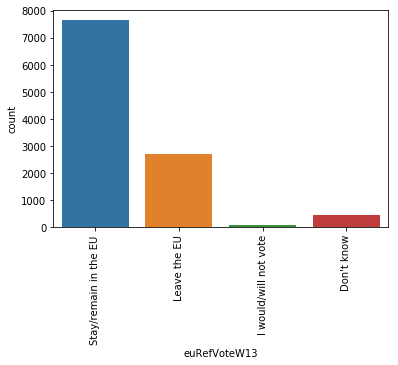

In [128]:
sns.countplot(BES_Panel["euRefVoteW13"][Labour])
plt.xticks(rotation=90);
BES_Panel["euRefVoteW13"][Labour].value_counts()/len(BES_Panel["euRefVoteW13"][Labour])

Leave the EU             0.537935
Stay/remain in the EU    0.373189
Don't know               0.049118
I would/will not vote    0.039758
Name: euRefVoteW13, dtype: float64

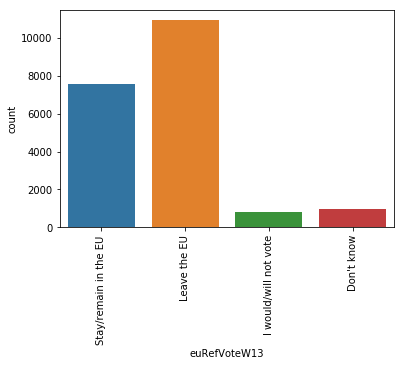

In [134]:
sns.countplot(BES_Panel["euRefVoteW13"][~Labour])
plt.xticks(rotation=90);
BES_Panel["euRefVoteW13"][~Labour].value_counts()/len(BES_Panel["euRefVoteW13"][~Labour].dropna())

In [69]:
BES_Panel["euRefVoteW13"][Labour].value_counts()/len(BES_Panel["euRefVoteW13"][Labour])

Stay/remain in the EU    0.701257
Leave the EU             0.248188
Don't know               0.041013
I would/will not vote    0.009542
Name: euRefVoteW13, dtype: float64

In [34]:
res_df = pd.DataFrame()

ptvs = [x for x in BES_reduced.columns if re.match("ptv\w*W13",x)]
res_df["Labour2017&Leave2017"] = BES_reduced_with_na[ptvs][Labour&Leave2017].mean().sort_values(ascending=False)

res_df["Labour2017&NotLeave2017"] = BES_reduced_with_na[ptvs][Labour&~Leave2017].mean().sort_values(ascending=False)

res_df["NotLabour2017&NotLeave2017"] = BES_reduced_with_na[ptvs][~Labour&~Leave2017].mean().sort_values(ascending=False)

res_df["NotLabour2017&Leave2017"] =  BES_reduced_with_na[ptvs][~Labour&Leave2017].mean().sort_values(ascending=False)
res_df

,Labour2017&Leave2017,Labour2017&NotLeave2017,NotLabour2017&NotLeave2017,NotLabour2017&Leave2017
ptvLabW13__Very likely,8.443659,9.102867,4.124807,2.015077
ptvGrnW13__Very likely,2.835341,4.807297,3.540851,1.503607
ptvUKIPW13__Very likely,2.645326,0.290661,0.697688,4.384674
ptvLDW13__Very likely,2.440239,4.381155,4.672886,1.764911
ptvConW13__Very likely,1.772297,1.097719,4.476557,7.502269


C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


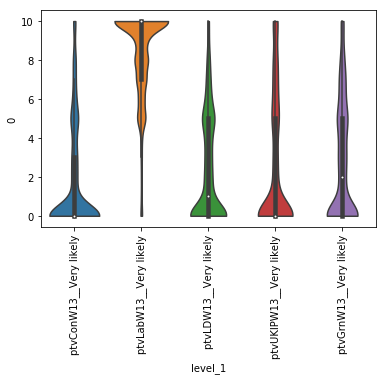

In [56]:
sns.violinplot(data = BES_reduced_with_na[ptvs][Labour&Leave2017].stack().reset_index().drop("level_0",axis=1),y=0,x="level_1", cut=0);
plt.xticks(rotation=90);

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


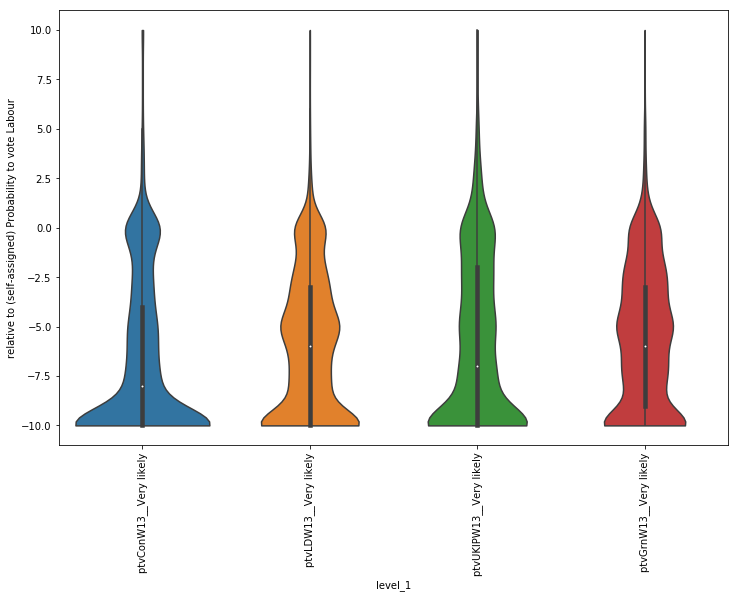

In [87]:
plt.figure(figsize=(12,8))
relative_to_lab_ptv = BES_reduced_with_na[ptvs][Labour&Leave2017].subtract( BES_reduced_with_na["ptvLabW13__Very likely"][Labour&Leave2017], axis=0 ).drop("ptvLabW13__Very likely",axis=1)
sns.violinplot(data = relative_to_lab_ptv.stack().reset_index().drop("level_0",axis=1),y=0,x="level_1", cut=0);
plt.xticks(rotation=90);
plt.ylabel("relative to (self-assigned) Probability to vote Labour");

In [66]:
relative_to_lab_ptv.mean()

ptvConW13__Very likely    -6.680792
ptvLDW13__Very likely     -5.998798
ptvUKIPW13__Very likely   -5.796016
ptvGrnW13__Very likely    -5.582757
dtype: float64

In [80]:
(relative_to_lab_ptv>0).mean()

ptvConW13__Very likely     0.028466
ptvLDW13__Very likely      0.019963
ptvUKIPW13__Very likely    0.060259
ptvGrnW13__Very likely     0.030684
dtype: float64

In [86]:
(relative_to_lab_ptv==0).mean()

ptvConW13__Very likely     0.096118
ptvLDW13__Very likely      0.070610
ptvUKIPW13__Very likely    0.080961
ptvGrnW13__Very likely     0.063216
dtype: float64

In [100]:
Leave_opts= relative_to_lab_ptv[["ptvConW13__Very likely","ptvUKIPW13__Very likely"]].max(axis=1)
Remain_opts= relative_to_lab_ptv[["ptvGrnW13__Very likely","ptvLDW13__Very likely"]].max(axis=1)


In [109]:
((Leave_opts>0) & (Leave_opts>=Remain_opts)).mean()
# 12.5% - indifferent
# 7.5% - prefer

0.07467652495378928

In [111]:
((Remain_opts>0) & (Leave_opts<=Remain_opts)).mean()
# 8.5% - indifferent
# 3.5% - prefer

0.0354898336414048

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


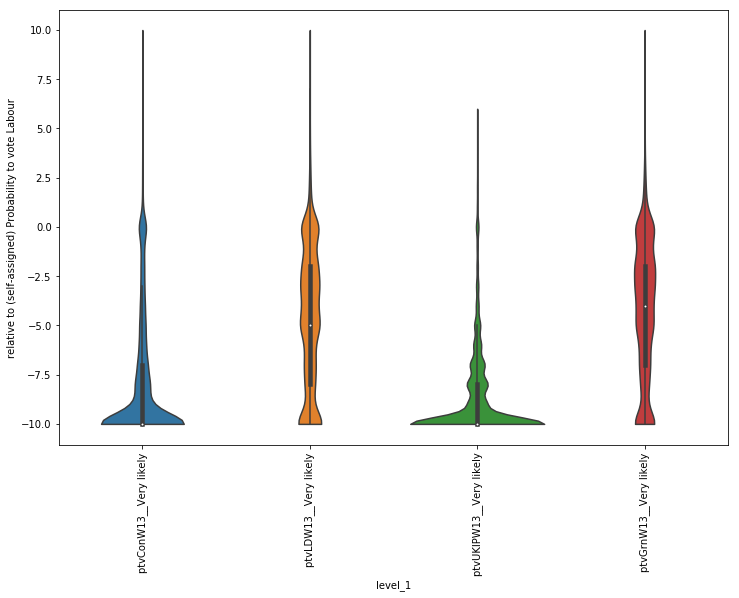

In [90]:
plt.figure(figsize=(12,8))
relative_to_lab_ptv_not_leave = BES_reduced_with_na[ptvs][Labour&~Leave2017].subtract( BES_reduced_with_na["ptvLabW13__Very likely"][Labour&~Leave2017], axis=0 ).drop("ptvLabW13__Very likely",axis=1)
sns.violinplot(data = relative_to_lab_ptv_not_leave.stack().reset_index().drop("level_0",axis=1),y=0,x="level_1", cut=0);
plt.xticks(rotation=90);
plt.ylabel("relative to (self-assigned) Probability to vote Labour");

In [91]:
relative_to_lab_ptv_not_leave.mean()

ptvConW13__Very likely    -8.010976
ptvLDW13__Very likely     -4.720870
ptvUKIPW13__Very likely   -8.818914
ptvGrnW13__Very likely    -4.281809
dtype: float64

In [92]:
(relative_to_lab_ptv_not_leave>0).mean()

ptvConW13__Very likely     0.012692
ptvLDW13__Very likely      0.033927
ptvUKIPW13__Very likely    0.005004
ptvGrnW13__Very likely     0.042348
dtype: float64

In [93]:
(relative_to_lab_ptv_not_leave==0).mean()

ptvConW13__Very likely     0.043935
ptvLDW13__Very likely      0.110081
ptvUKIPW13__Very likely    0.010984
ptvGrnW13__Very likely     0.113254
dtype: float64

In [112]:
Leave_opts= relative_to_lab_ptv_not_leave[["ptvConW13__Very likely","ptvUKIPW13__Very likely"]].max(axis=1)
Remain_opts= relative_to_lab_ptv_not_leave[["ptvGrnW13__Very likely","ptvLDW13__Very likely"]].max(axis=1)


In [114]:
((Leave_opts==0) & (Leave_opts>=Remain_opts)).mean()
# Leave
# 3.5% - indifferent
# 1.5% - prefer

0.03880888454967049

In [116]:
((Remain_opts==0) & (Leave_opts<=Remain_opts)).mean()
# 17% - indifferent
# 6% - prefer

0.1708567244325116

In [162]:
res_df = pd.DataFrame()

ptvs = [x for x in BES_reduced.columns if re.match("ptv\w*W13",x)]
res_df["Labour2017&Leave"] = BES_reduced_with_na[ptvs][Labour&Leave2017].mean().sort_values(ascending=False)

res_df["Labour2017&Remain"] = BES_reduced_with_na[ptvs][Labour&Remain2017].mean().sort_values(ascending=False)

res_df["Labour2017&EUDK"] = BES_reduced_with_na[ptvs][Labour&EUDK2017].mean().sort_values(ascending=False)

res_df["NotLabour2017&Remain"] = BES_reduced_with_na[ptvs][~Labour&Remain2017].mean().sort_values(ascending=False)

res_df["NotLabour2017&Leave"] =  BES_reduced_with_na[ptvs][~Labour&Leave2017].mean().sort_values(ascending=False)

res_df["NotLabour2017&EUDK"] =  BES_reduced_with_na[ptvs][~Labour&EUDK2017].mean().sort_values(ascending=False)
res_df

,Labour2017&Leave,Labour2017&Remain,Labour2017&EUDK,NotLabour2017&Remain,NotLabour2017&Leave,NotLabour2017&EUDK
ptvLabW13__Very likely,8.443659,9.140005,8.517021,4.305049,2.015077,3.123149
ptvGrnW13__Very likely,2.835341,4.865757,3.863436,3.771544,1.503607,2.257588
ptvUKIPW13__Very likely,2.645326,0.246575,0.993576,0.531546,4.384674,1.605105
ptvLDW13__Very likely,2.440239,4.434138,3.521158,4.990835,1.764911,2.895981
ptvConW13__Very likely,1.772297,1.060631,1.693478,4.416830,7.502269,4.807276


,Labour2017&Leave,Labour2017&Remain,NotLabour2017&Remain,NotLabour2017&Leave
ptvLabW13__Very likely,8.506798,9.148406,4.054959,2.074189
ptvGrnW13__Very likely,3.009709,4.923561,3.584321,1.562328
ptvLDW13__Very likely,2.607130,4.470727,4.894096,1.829326
ptvUKIPW13__Very likely,2.406993,0.206494,0.495290,4.393012
ptvConW13__Very likely,1.756406,1.040430,4.829936,7.401907


In [73]:
# [x for x in BES_reduced.columns if re.match("likeLucas",x)]

['likeLucasW12__Strongly like']

In [126]:
likes_df = pd.DataFrame()
likes = [x for x in BES_reduced.columns if re.match("like\w*W13",x)]
likes = likes + ['likeFarageW11__Strongly like','likeLucasW12__Strongly like']
likes_df["Lab&Leave2017"]     = BES_reduced_with_na[likes][Labour&Leave2017].mean().sort_values(ascending=False)

likes_df["Lab&Remain2017"]    = BES_reduced_with_na[likes][Labour&Remain2017].mean().sort_values(ascending=False)

likes_df["Lab&EUDK2017"]    = BES_reduced_with_na[likes][Labour&EUDK2017].mean().sort_values(ascending=False)

likes_df["NotLab&Remain2017"] = BES_reduced_with_na[likes][~Labour&Remain2017].mean().sort_values(ascending=False)

likes_df["NotLab&Leave2017"]  = BES_reduced_with_na[likes][~Labour&Leave2017].mean().sort_values(ascending=False)

likes_df["NotLab&EUDK2017"] = BES_reduced_with_na[likes][~Labour&EUDK2017].mean().sort_values(ascending=False)
likes_df

,Lab&Leave2017,Lab&Remain2017,Lab&EUDK2017,NotLab&Remain2017,NotLab&Leave2017,NotLab&EUDK2017
likeLabW13__Strongly like,7.531689,8.119193,7.574553,4.402694,2.182608,3.531931
likeCorbynW13__Strongly like,7.074358,7.916744,7.500000,4.369296,1.803968,3.329368
likeGrnW13__Strongly like,4.398502,6.277577,5.379545,5.104741,2.621249,3.753962
likeFarageW11__Strongly like,4.327502,0.816380,2.471751,1.415055,5.878914,3.159091
likeLucasW12__Strongly like,4.197931,6.178526,5.234043,5.136315,2.524051,3.630814
likeLDW13__Strongly like,3.189988,4.880365,3.949891,4.994117,2.311387,3.488409
likeUKIPW13__Strongly like,3.133385,0.436712,1.449679,0.859401,4.699464,2.212864
likeFarronW13__Strongly like,3.068151,4.343954,3.648579,4.467338,2.198169,3.257491
likeSturgeonW13__Strongly like,2.438289,4.720825,3.327791,4.069336,1.108321,2.514446
likeNuttallW13__Strongly like,2.340446,0.703048,1.441011,1.102823,3.174699,2.008114


In [ ]:
#################################################################################
# thought I was finished ...
# then I Stephen Bush in NS podcast saying that Labour stance was pitched at
# picking up Leave voters *they don't already have*
# ... on the face of it, that sounds batshit

In [117]:
res_df = pd.DataFrame()

ptvs = [x for x in BES_reduced.columns if re.match("ptv\w*W13",x)]
res_df["Labour2017&Leave2017"] = BES_reduced_with_na[ptvs][Labour&Leave2017].mean().sort_values(ascending=False)

res_df["Labour2017&NotLeave2017"] = BES_reduced_with_na[ptvs][Labour&~Leave2017].mean().sort_values(ascending=False)

res_df["NotLabour2017&NotLeave2017"] = BES_reduced_with_na[ptvs][~Labour&~Leave2017].mean().sort_values(ascending=False)

res_df["NotLabour2017&Leave2017"] =  BES_reduced_with_na[ptvs][~Labour&Leave2017].mean().sort_values(ascending=False)
res_df

,Labour2017&Leave2017,Labour2017&NotLeave2017,NotLabour2017&NotLeave2017,NotLabour2017&Leave2017
ptvLabW13__Very likely,8.443659,9.102867,4.124807,2.015077
ptvGrnW13__Very likely,2.835341,4.807297,3.540851,1.503607
ptvUKIPW13__Very likely,2.645326,0.290661,0.697688,4.384674
ptvLDW13__Very likely,2.440239,4.381155,4.672886,1.764911
ptvConW13__Very likely,1.772297,1.097719,4.476557,7.502269


C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


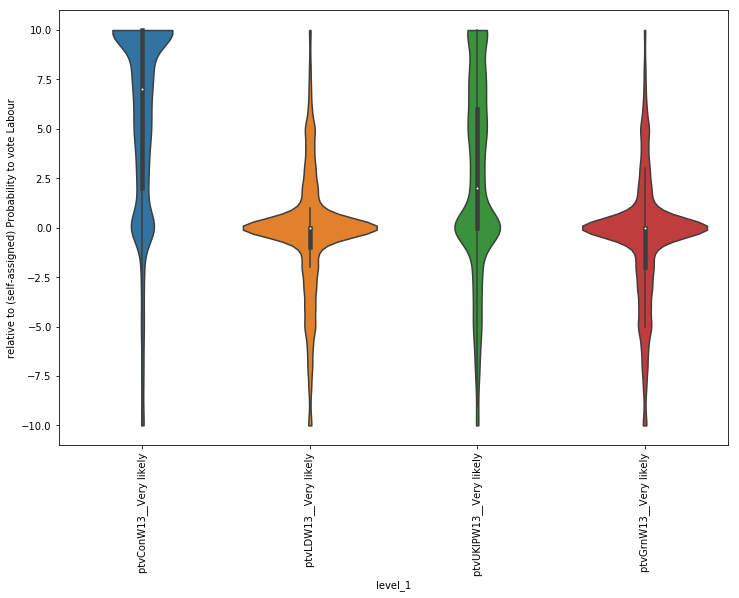

In [136]:
plt.figure(figsize=(12,8))
relative_to_lab_ptv_leave = BES_reduced_with_na[ptvs][(~Labour)&Leave2017].subtract( BES_reduced_with_na["ptvLabW13__Very likely"][(~Labour)&Leave2017], axis=0 ).drop("ptvLabW13__Very likely",axis=1)
sns.violinplot(data = relative_to_lab_ptv_leave.stack().reset_index().drop("level_0",axis=1),y=0,x="level_1", cut=0);
plt.xticks(rotation=90);
plt.ylabel("relative to (self-assigned) Probability to vote Labour");

In [151]:
Leave_opts= relative_to_lab_ptv_leave[["ptvConW13__Very likely","ptvUKIPW13__Very likely"]].max(axis=1)
Remain_opts= relative_to_lab_ptv_leave[["ptvGrnW13__Very likely","ptvLDW13__Very likely"]].max(axis=1)
All_opts = relative_to_lab_ptv_leave[["ptvGrnW13__Very likely","ptvLDW13__Very likely","ptvConW13__Very likely","ptvUKIPW13__Very likely"]].max(axis=1)

In [153]:
(All_opts==0).mean(), (All_opts<0).mean()

(0.08215038007143512, 0.034252220899349754)

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


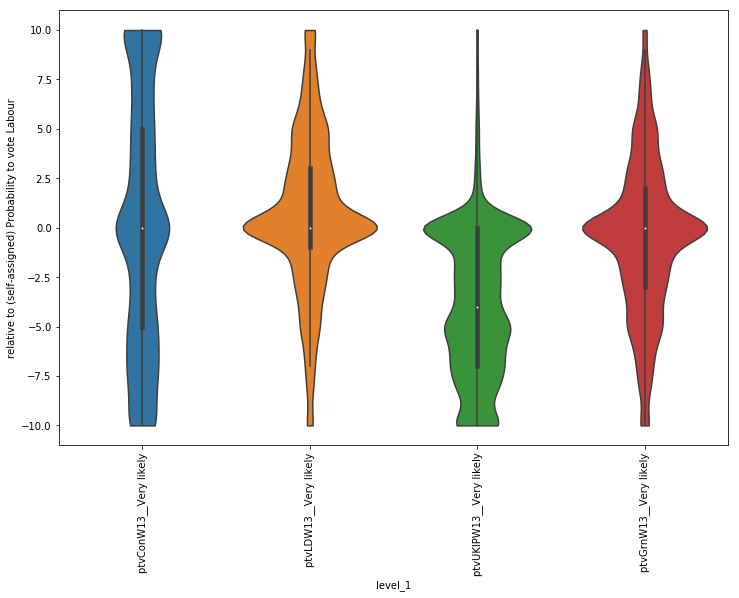

In [155]:
plt.figure(figsize=(12,8))
relative_to_lab_ptv_remain = BES_reduced_with_na[ptvs][(~Labour)&Remain2017].subtract( BES_reduced_with_na["ptvLabW13__Very likely"][(~Labour)&Remain2017], axis=0 ).drop("ptvLabW13__Very likely",axis=1)
sns.violinplot(data = relative_to_lab_ptv_remain.stack().reset_index().drop("level_0",axis=1),y=0,x="level_1", cut=0);
plt.xticks(rotation=90);
plt.ylabel("relative to (self-assigned) Probability to vote Labour");

In [157]:
Leave_opts= relative_to_lab_ptv_remain[["ptvConW13__Very likely","ptvUKIPW13__Very likely"]].max(axis=1)
Remain_opts= relative_to_lab_ptv_remain[["ptvGrnW13__Very likely","ptvLDW13__Very likely"]].max(axis=1)
All_opts = relative_to_lab_ptv_remain[["ptvGrnW13__Very likely","ptvLDW13__Very likely","ptvConW13__Very likely","ptvUKIPW13__Very likely"]].max(axis=1)

(All_opts==0).mean(), (All_opts<0).mean()

(0.16105610561056105, 0.10481848184818482)

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


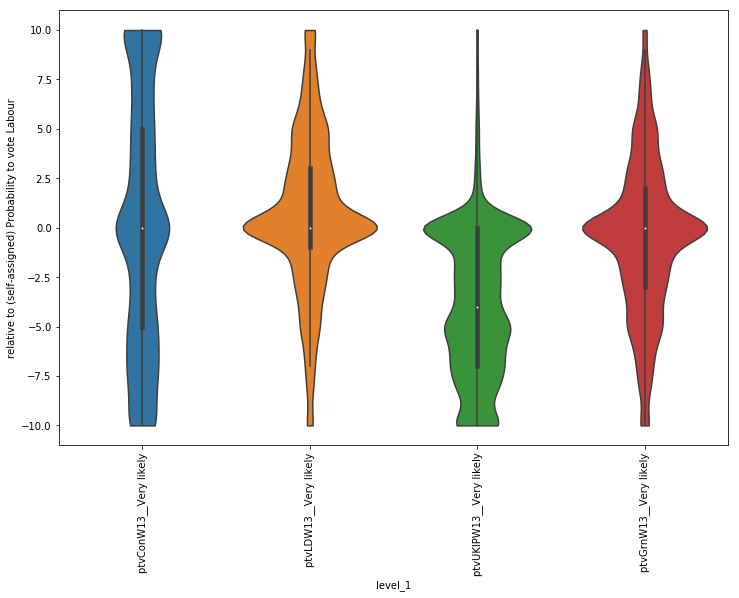

In [159]:
plt.figure(figsize=(12,8))
relative_to_lab_ptv_dk = BES_reduced_with_na[ptvs][(~Labour)&EUDK2017].subtract( BES_reduced_with_na["ptvLabW13__Very likely"][(~Labour)&EUDK2017], axis=0 ).drop("ptvLabW13__Very likely",axis=1)
sns.violinplot(data = relative_to_lab_ptv_remain.stack().reset_index().drop("level_0",axis=1),y=0,x="level_1", cut=0);
plt.xticks(rotation=90);
plt.ylabel("relative to (self-assigned) Probability to vote Labour");

In [160]:
Leave_opts= relative_to_lab_ptv_dk[["ptvConW13__Very likely","ptvUKIPW13__Very likely"]].max(axis=1)
Remain_opts= relative_to_lab_ptv_dk[["ptvGrnW13__Very likely","ptvLDW13__Very likely"]].max(axis=1)
All_opts = relative_to_lab_ptv_dk[["ptvGrnW13__Very likely","ptvLDW13__Very likely","ptvConW13__Very likely","ptvUKIPW13__Very likely"]].max(axis=1)

(All_opts==0).mean(), (All_opts<0).mean()

(0.19678492239467849, 0.07926829268292683)

In [ ]:
# .08,.03 Leave
# .16,.10 Remain
# .20,.08 DK




In [ ]:
### Random thought - is there a soc con/lib correlation between "respect for political success/power"? E.g. support for Blair from Sun readers
# Look at shifts in LikeCorbyn before/after campaign and correlation with soc lib/con

In [163]:
[x for x in BES_reduced_with_na.columns if re.match("likeCorbyn",x)]

['likeCorbynW7__Strongly like',
 'likeCorbynW8__Strongly like',
 'likeCorbynW9__Strongly like',
 'likeCorbynW10__Strongly like',
 'likeCorbynW11__Strongly like',
 'likeCorbynW12__Strongly like',
 'likeCorbynW13__Strongly like']

In [165]:
Corb_shift = BES_reduced_with_na['likeCorbynW13__Strongly like']-BES_reduced_with_na['likeCorbynW12__Strongly like']

In [168]:
pan_dataset_values = pd.read_csv(BES_small_data_files + "pan_dataset_values"+".csv")

In [170]:
pan_dataset_values.corrwith(Corb_shift)

id                  -0.001255
genImmigSentiment    0.120237
raw_gen_lr_vals      0.115484
raw_gen_al_vals     -0.069145
xt_std_lr            0.111347
xt_std_al           -0.068017
lr_uniform           0.114512
al_uniform          -0.067070
dtype: float64

In [ ]:
# Nah - shift is mostly where you'd expect it - among the people who swung to voting Labour (left-liberals-pro-immigration)